# Simple Lorenz Simulator in NumPy

The Lorenz equations are a prototypical example of **deterministic chaos**. They
are a system of three **nonlinear** ODEs

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma(y - x), \\
\frac{dy}{dt} &= x(\rho - z) - y, \\
\frac{dz}{dt} &= xy - \beta z.
\end{aligned}
$$

The three variables can be combined into the state vector $u = (x, y, z) \in
\mathbb{R}^3$. Given an initial state $u^{[0]}$, we can simulate a trajectory by
recursively applying a simulator to it

$$
u^{[t+1]} = \mathcal{P}(u^{[t]}).
$$

Here, this simulator will be due to the Runge-Kutta 4 method. Writing the
right-hand side of the Lorenz equation as $\frac{du}{dt} = f(u)$, the scheme
reads

$$
\begin{aligned}
k_1 &= f(u^{[t]}), \\
k_2 &= f(u^{[t]} + \frac{\Delta t}{2} k_1), \\
k_3 &= f(u^{[t]} + \frac{\Delta t}{2} k_2), \\
k_4 &= f(u^{[t]} + \Delta t \, k_3), \\
u^{[t+1]} &= u^{[t]} + \frac{\Delta t}{6} (k_1 + 2k_2 + 2k_3 + k_4).
\end{aligned}
$$

We can then display the trajectory $ \{ u^{[0]}, u^{[1]}, \dots, u^{[T]} \} $ in
3D space which is the classical butterfly shape.

We will use the settings as in the original paper by Lorenz (1), i.e. $\sigma = 10$,
$\rho = 28$ and $\beta = 8/3$ together with $\Delta t = 0.01$.

---

(1) E. N. Lorenz, "Deterministic Nonperiodic Flow", Journal of the Atmospheric
Sciences, 1963,
https://journals.ametsoc.org/view/journals/atsc/20/2/1520-0469_1963_020_0130_dnf_2_0_co_2.xml

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def lorenz_rhs(u, *, sigma, rho, beta):
    x, y, z = u
    x_dot = sigma * (y - x)
    y_dot = x * (rho - z) - y
    z_dot = x * y - beta * z
    u_dot = np.array([x_dot, y_dot, z_dot])
    return u_dot

In [9]:
class LorenzStepperRK4:
    def __init__(self, dt=0.001, *, sigma=10, rho=28, beta=8/3):
        self.dt = dt
        self.sigma = sigma
        self.rho = rho
        self.beta = beta

    def __call__(self, u_prev):
        lorenz_rhs_fixed = lambda u: lorenz_rhs(
            u,
            sigma=self.sigma,
            rho=self.rho,
            beta=self.beta,
        )
        k_1 = lorenz_rhs_fixed(u_prev)
        k_2 = lorenz_rhs_fixed(u_prev + 0.5 * self.dt * k_1)
        k_3 = lorenz_rhs_fixed(u_prev + 0.5 * self.dt * k_2)
        k_4 = lorenz_rhs_fixed(u_prev + self.dt * k_3)
        u_next = u_prev + self.dt * (k_1 + 2*k_2 + 2*k_3 + k_4)/6
        return u_next

In [10]:
lorenz_stepper = LorenzStepperRK4()

In [11]:
u_0 = np.ones(3)

In [13]:
trj = [u_0,]
u_current = u_0
for i in range(50000):
    u_current = lorenz_stepper(u_current)
    trj.append(u_current)
trj = np.array(trj)

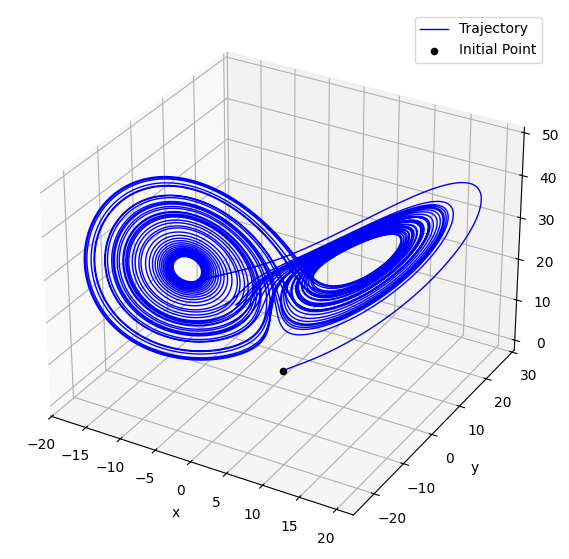

In [14]:
fig, ax = plt.subplots(
    subplot_kw={"projection": "3d"},
    figsize=(7, 7),
)

ax.plot(
    trj[:, 0],
    trj[:, 1],
    trj[:, 2],
    lw=1.0,
    color="blue",
    label="Trajectory",
)
ax.scatter3D(
    trj[0, 0],
    trj[0, 1],
    trj[0, 2],
    color="black",
    label="Initial Point",
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend()

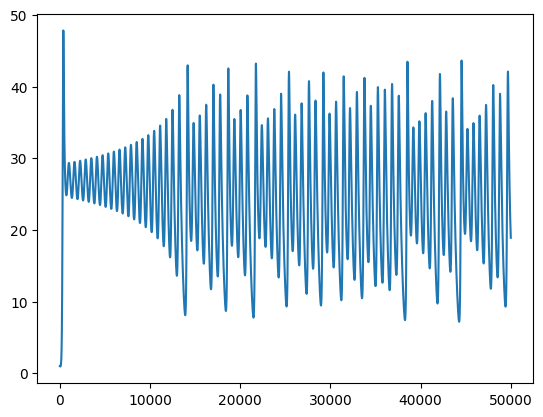

In [15]:
plt.plot(trj[:, 2])

In [16]:
def find_maxima_in_z(trj_):
    z_trj_left = trj_[:-2, 2]
    z_trj_center = trj_[1:-1, 2]
    z_trj_right = trj_[2:, 2]

    is_maximum = (z_trj_center > z_trj_left) & (z_trj_center > z_trj_right)

    maximal_values = z_trj_center[is_maximum]
    return maximal_values

In [17]:
maximal_values = find_maxima_in_z(trj)

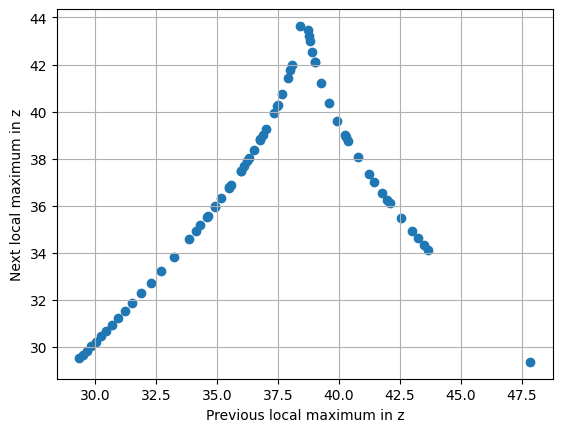

In [18]:
plt.scatter(maximal_values[:-1], maximal_values[1:])
plt.xlabel("Previous local maximum in z")
plt.ylabel("Next local maximum in z")
plt.grid()

In [20]:
def produce_trj(init, n_steps=50000):
    trj = [init,]
    u_current = init
    for i in range(n_steps):
        u_current = lorenz_stepper(u_current)
        trj.append(u_current)
    trj = np.array(trj)
    return trj

In [21]:
trj = produce_trj(u_0)

In [22]:
u_0_warmed = trj[-1]
u_0_warmed_noise = u_0_warmed + 1e-8 * (np.random.rand(3) * 2 - 1)
np.linalg.norm(u_0_warmed_noise - u_0_warmed)
u_warmed_trj = produce_trj(u_0_warmed)
u_warmed_noise_trj = produce_trj(u_0_warmed_noise)
distance_trj = np.linalg.norm(u_warmed_noise_trj - u_warmed_trj, axis=1)

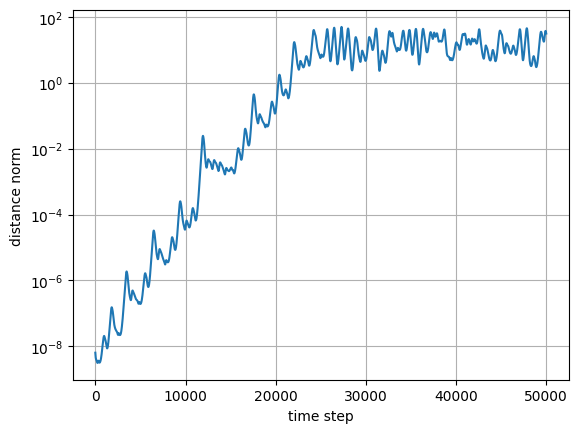

In [23]:
plt.semilogy(distance_trj)
plt.xlabel("time step")
plt.ylabel("distance norm")
plt.grid()

In [30]:
time_points = np.arange(len(distance_trj)) * lorenz_stepper.dt

lyapunov_exponent, log_offset = np.polyfit(time_points[:21000], np.log(distance_trj)[:21000], 1)

lyapunov_exponent

0.8944784241896255

Text(0, 0.5, 'distance norm')

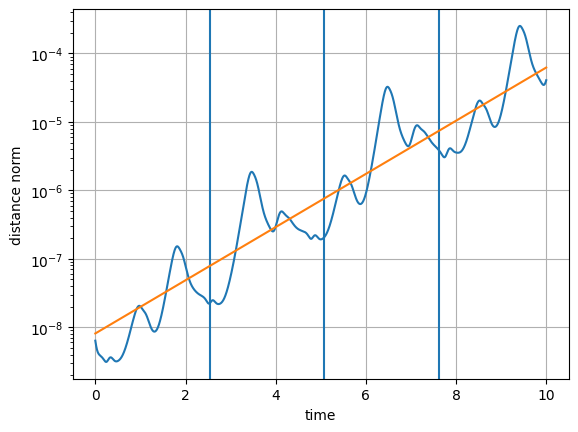

In [32]:
TRUE_LYAPUNOV_EXPONENT = 0.9056 # From better job other people have done !!!

plt.semilogy(time_points[:10000], distance_trj[:10000])
plt.grid()
plt.vlines(1 * 2.3 * 1/TRUE_LYAPUNOV_EXPONENT, 1e-9, 1e-3)
plt.vlines(2 * 2.3 * 1/TRUE_LYAPUNOV_EXPONENT, 1e-9, 1e-3)
plt.vlines(3 * 2.3 * 1/TRUE_LYAPUNOV_EXPONENT, 1e-9, 1e-3)
plt.plot(
    time_points[:10000],
    np.exp(log_offset + lyapunov_exponent * time_points[:10000])
)
plt.xlabel("time")
plt.ylabel("distance norm")